In [1]:
import pandas as pd

import sys
sys.path.append('../')

from helpers.utils import read_docx_to_dict, fetch_biggest_text, mark_use_row, check_text_likeness, parse_words
from helpers.utils import fetch_climate_words_in_words, fetch_climate_phrases_in_text, words_found_master_list, clean_lemmatized_words, lemmatize_words, master_stopwords_list, highlight_words

from helpers.words import CLIMATE_CHANGE_RELATED_WORDS, CLIMATE_CHANGE_RELATED_PHRASES
from helpers.cc_words import CC_WORDS, CC_PHRASES

In [2]:
STATION = 'CBS'

filename = f"data/{STATION}/Analysis_Fire_12_30_21_CBS.docx"
miami_dallas = f"data/{STATION}/Analysis_12_30_21_Colorado_Fire_CBS_w_DallasMiami.docx"

In [3]:
data = read_docx_to_dict(filename)
data2 = read_docx_to_dict(miami_dallas)

In [4]:
pd.options.display.max_rows = 500

# create dataframe
df1 = pd.DataFrame.from_dict(data)
df2 = pd.DataFrame.from_dict(data2)

print(len(df1))
print(len(df2))

75
10


In [5]:
df = pd.concat([df1, df2], ignore_index=True)
df.index += 1 # set index to 1
len(df)

85

In [6]:
df['text'] = df['text'].str.lower()

In [7]:
# df.head(5)

In [8]:
# mark non dups
non_dups = dict()
for row in df.index:
    if df['text'][row] not in non_dups:
        non_dups[df['text'][row]] = { 'index': row }

In [9]:
# mark non dups
non_dup_index = [i['index'] for i in non_dups.values()]
df['dup'] = None

for row in df.index:
    if row in non_dup_index:
        df['dup'][row] = False
    else:
        df['dup'][row] = True 

In [10]:
# df.head(5)

In [11]:
# only get ratio for non dups
clean_df = df[df['dup'] == False]

clean_df['matches'] = clean_df.apply(lambda row: check_text_likeness(clean_df, row['text']), axis=1)

/Users/loren/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
clean_df['row_to_use'] = clean_df.apply(lambda row: fetch_biggest_text(clean_df, row['matches']), axis=1)

/Users/loren/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
mark_use_row(clean_df)

/Users/loren/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/loren/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


'done'

In [14]:
# df.head(5)

In [15]:
clean_df.head(5)

time                    location station  \
1  2021-12-30 6:49 PM          Phoenix (Prescott)    KPHO   
2  2021-12-30 6:48 PM          Phoenix (Prescott)    KPHO   
3  2021-12-30 6:37 PM            Ft. Myers-Naples    WINK   
4  2021-12-30 6:37 PM  Greensboro-H.Point-W.Salem    WFMY   
5    21-12-30 6:37 PM                     Atlanta    WGCL   

                                                text    dup  \
1  have been destroyed. ap, the associated press ...  False   
2  kusa, the nbc affiliate in denver, this is in ...  False   
3  several communities were evacuated because of ...  False   
4  the evening ending overnight. several communit...  False   
5  the evening ending overnight. several communit...  False   

                                         matches  row_to_use use_row  
1                                            [1]           1    True  
2                                            [2]           2    True  
3  [3, 4, 5, 10, 11, 15, 17, 18, 30, 41, 57, 71]          15   False  
4  [3, 4, 5, 10, 11, 15, 17, 18, 30, 41, 57, 71]          15   False  
5  [3, 4, 5, 10, 11, 15, 17, 18, 30, 41, 57, 71]          15   False

In [16]:
# merge matches
df = pd.merge(df, clean_df[["matches", "row_to_use", "use_row"]], left_index=True, right_index=True, how='left')

In [17]:
df['use_row'] = df['use_row'].fillna(False)

In [18]:
df['matches'] = df['matches'].fillna('N/A')

In [19]:
# df.head(15)

In [20]:
df['words'] = df['text'].str.lower().str.replace(',', '').str.replace('>', '').str.replace('.', '').str.replace('\n', '').str.replace('’', "'").str.replace(
    '!', '').str.replace('?', '').str.replace('%', '').str.replace(')', '').str.replace('(', '').str.replace('_', '').str.replace(':', '').str.strip().str.split(' ')

/Users/loren/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
/Users/loren/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [21]:
df['cc_clean_words'] = df.apply(lambda row: parse_words(row['words'], use_words=True), axis=1)

In [22]:
df['my_clean_words'] = df.apply(lambda row: parse_words(row['words'], use_words=False), axis=1)

In [23]:
# df.head(5)

In [24]:
df['cc_climate_words_found'] = df.apply(lambda row: fetch_climate_words_in_words(row['cc_clean_words'], use_words=True), axis=1)

In [25]:
df['my_climate_words_found'] = df.apply(lambda row: fetch_climate_words_in_words(row['my_clean_words'], use_words=False), axis=1)

In [26]:
df.head(5)

time                    location station  \
1  2021-12-30 6:49 PM          Phoenix (Prescott)    KPHO   
2  2021-12-30 6:48 PM          Phoenix (Prescott)    KPHO   
3  2021-12-30 6:37 PM            Ft. Myers-Naples    WINK   
4  2021-12-30 6:37 PM  Greensboro-H.Point-W.Salem    WFMY   
5    21-12-30 6:37 PM                     Atlanta    WGCL   

                                                text    dup  \
1  have been destroyed. ap, the associated press ...  False   
2  kusa, the nbc affiliate in denver, this is in ...  False   
3  several communities were evacuated because of ...  False   
4  the evening ending overnight. several communit...  False   
5  the evening ending overnight. several communit...  False   

                                         matches  row_to_use  use_row  \
1                                            [1]         1.0     True   
2                                            [2]         2.0     True   
3  [3, 4, 5, 10, 11, 15, 17, 18, 30, 41, 57, 71]        15.0    False   
4  [3, 4, 5, 10, 11, 15, 17, 18, 30, 41, 57, 71]        15.0    False   
5  [3, 4, 5, 10, 11, 15, 17, 18, 30, 41, 57, 71]        15.0    False   

                                               words  \
1  [have, been, destroyed, ap, the, associated, p...   
2  [kusa, the, nbc, affiliate, in, denver, this, ...   
3  [several, communities, were, evacuated, becaus...   
4  [the, evening, ending, overnight, several, com...   
5  [the, evening, ending, overnight, several, com...   

                                      cc_clean_words  \
1  [have, been, destroyed, ap, the, associated, p...   
2  [kusa, the, nbc, affiliate, in, denver, this, ...   
3  [several, communities, were, evacuated, becaus...   
4  [the, evening, ending, overnight, several, com...   
5  [the, evening, ending, overnight, several, com...   

                                      my_clean_words cc_climate_words_found  \
1  [have, been, destroyed, ap, the, associated, p...                     []   
2  [kusa, the, nbc, affiliate, in, denver, this, ...                     []   
3  [several, communities, were, evacuated, becaus...       [risk, forecast]   
4  [the, evening, ending, overnight, several, com...       [risk, forecast]   
5  [the, evening, ending, overnight, several, com...       [risk, forecast]   

  my_climate_words_found  
1                     []  
2                     []  
3               [severe]  
4               [severe]  
5               [severe]

In [27]:
df['cc_climate_phrases_found'] = df.apply(lambda row: fetch_climate_phrases_in_text(row['text'], use_phrases=True), axis=1)

In [28]:
df['my_climate_phrases_found'] = df.apply(lambda row: fetch_climate_phrases_in_text(row['text'], use_phrases=False), axis=1)

In [29]:
# save data to csv
csv = f'reports/{STATION}/{STATION}.csv'
df.to_csv(csv, encoding='utf-8')

In [30]:
# get unique segments that were aired
unique_df = df[df['use_row']]

In [31]:
# unique_df

In [32]:
# generate list of words found for comparison 
words_found = words_found_master_list(unique_df['cc_clean_words'])
len(words_found)

3558

In [33]:
# clean/distill words to root words (playing, played -> play)
clean_lemma_words = clean_lemmatized_words(lemmatize_words(words_found))

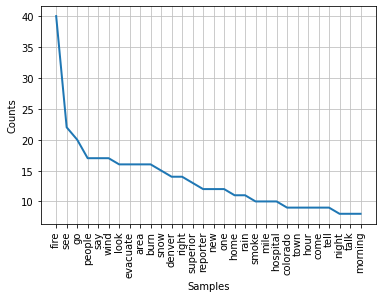

In [34]:
# get frequency distribution of words
from nltk.probability import FreqDist

lfdist = FreqDist(clean_lemma_words)
lfdist

import matplotlib.pyplot as plt
lfdist.plot(30,cumulative=False)
plt.show()

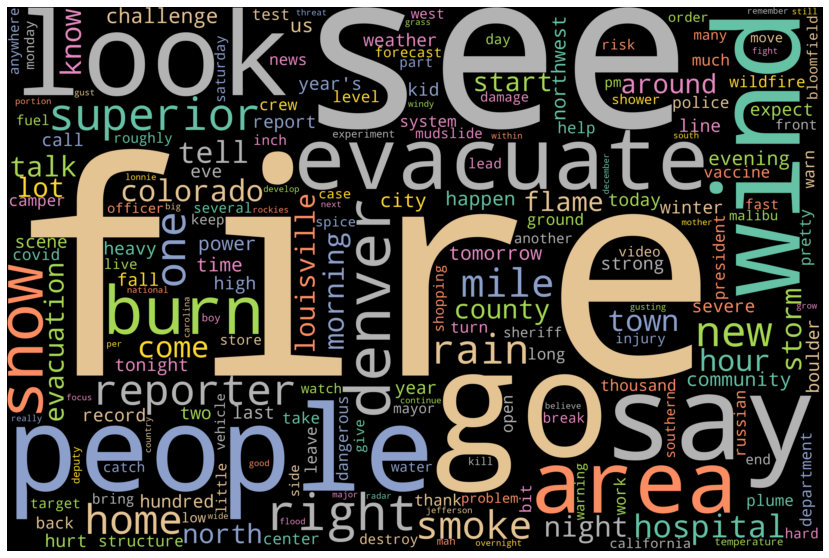

In [35]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

# generate word cloud without stopwords (the, a, an, etc), for all words post lemmatization
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = master_stopwords_list()).generate_from_frequencies(lfdist)

# Plot
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()

word_cloud_png = f'reports/{STATION}/word_cloud.png'
plt.savefig(word_cloud_png)

                     counts
Words                      
Climate-related          46
Non Climate-related    1708


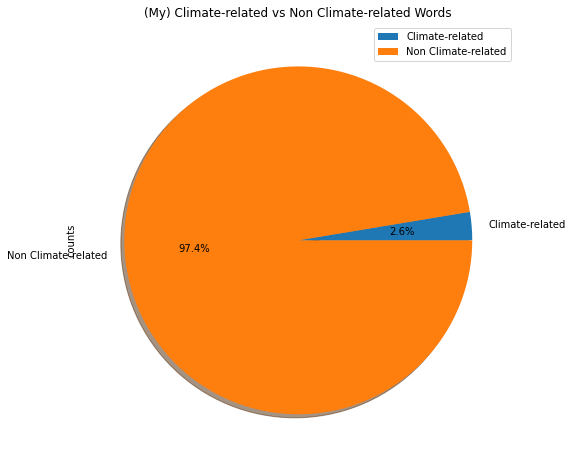

In [36]:
# MY
# my climate change related words

# Generate word counts, get percent of my climate change related words among total words
my_words_found = words_found_master_list(unique_df['my_clean_words'])
my_clean_lemma_words = clean_lemmatized_words(lemmatize_words(my_words_found))
my_lfdist = FreqDist(my_clean_lemma_words)

my_words_df = pd.DataFrame(my_lfdist.items(), columns=['Word', 'Count'])

my_words_df.sort_values(by=['Count'], ascending=False, inplace=True)


# get my climate change related words
my_climate_change_words_df = my_words_df.loc[my_words_df['Word'].isin(CLIMATE_CHANGE_RELATED_WORDS)]

my_climate_words_count = my_climate_change_words_df['Count'].sum()
my_non_climate_words_count = my_words_df['Count'].sum() - my_climate_words_count

my_comparison_df = pd.DataFrame({'Words': ['Climate-related', 'Non Climate-related'],
                             'counts': [my_climate_words_count, my_non_climate_words_count]})
my_comparison_df.set_index('Words', inplace=True)
print(my_comparison_df)

plot = my_comparison_df.plot.pie(y='counts', title="(My) Climate-related vs Non Climate-related Words", legend=True, autopct='%1.1f%%', shadow=True, figsize=(8, 8))

fig = plot.get_figure()

my_pie_chart_png = f'reports/{STATION}/my_comparison.png'
fig.savefig(my_pie_chart_png)

['high', 'report', 'severe', 'record', 'wildfire', 'temperature', 'fuel', 'rise', 'ice', 'heat', 'effect', 'degree', 'warm', 'effort', 'extreme', 'drought', 'history', 'energy']


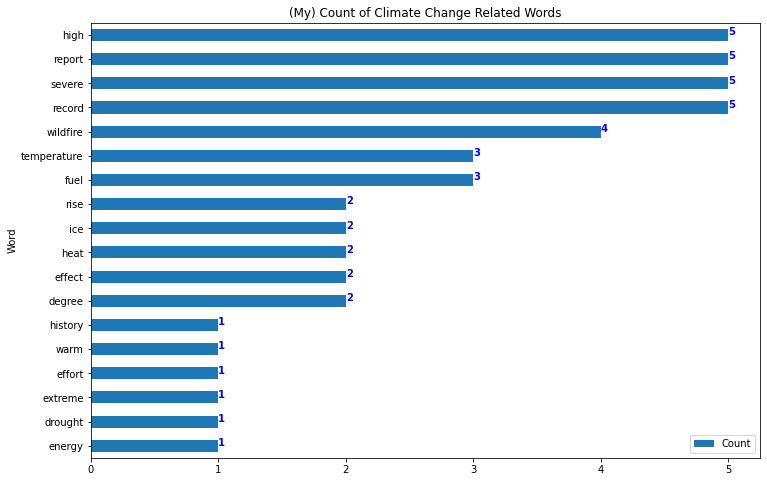

In [37]:
# MY
# my climated related words found -- frequencies
my_climate_change_words_found = list(my_climate_change_words_df['Word'].unique())
print(my_climate_change_words_found)

# set figure size
fig, ax = plt.subplots(figsize=(12, 8))

# plot horizontal bar plot
my_climate_change_words_df.sort_values(by='Count').plot.barh(x="Word", y="Count", ax=ax)
# set the title
plt.title("(My) Count of Climate Change Related Words")

for i, v in enumerate(my_climate_change_words_df['Count'].sort_values()):
    ax.text(v, i , str(v),
            color = 'blue', fontweight = 'bold')

# plt.show()
my_breakdown_png = f'reports/{STATION}/my-climate-related-words-breakdown.png'
plt.savefig(my_breakdown_png, transparent=False)

                     counts
Words                      
Climate-related          16
Non Climate-related    1738


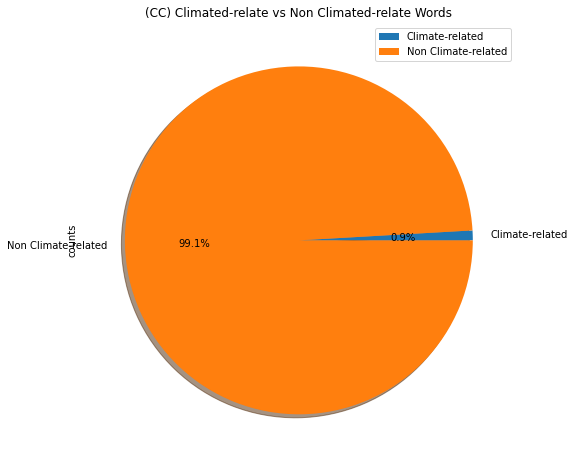

In [38]:
# CC
# cc climate change related words

# Generate word counts, get percent of my climate change related words among total words
cc_words_df = pd.DataFrame(lfdist.items(), columns=['Word', 'Count'])
cc_words_df.sort_values(by=['Count'], ascending=False, inplace=True)


# get cc climate change related words
cc_climate_change_words_df = cc_words_df.loc[cc_words_df['Word'].isin(CC_WORDS)]

cc_climate_words_count = cc_climate_change_words_df['Count'].sum()
cc_non_climate_words_count = cc_words_df['Count'].sum() - cc_climate_words_count

cc_comparison_df = pd.DataFrame({'Words': ['Climate-related', 'Non Climate-related'],
                             'counts': [cc_climate_words_count, cc_non_climate_words_count]})
cc_comparison_df.set_index('Words', inplace=True)
print(cc_comparison_df)

plot = cc_comparison_df.plot.pie(y='counts', title="(CC) Climated-relate vs Non Climated-relate Words", legend=True, autopct='%1.1f%%', shadow=True, figsize=(8, 8))

fig = plot.get_figure()

pie_chart_png_cc = f'reports/{STATION}/cc_comparison.png'
fig.savefig(pie_chart_png_cc)

['wildfire', 'forecast', 'risk', 'heat', 'hot', 'extreme', 'drought', 'probability']


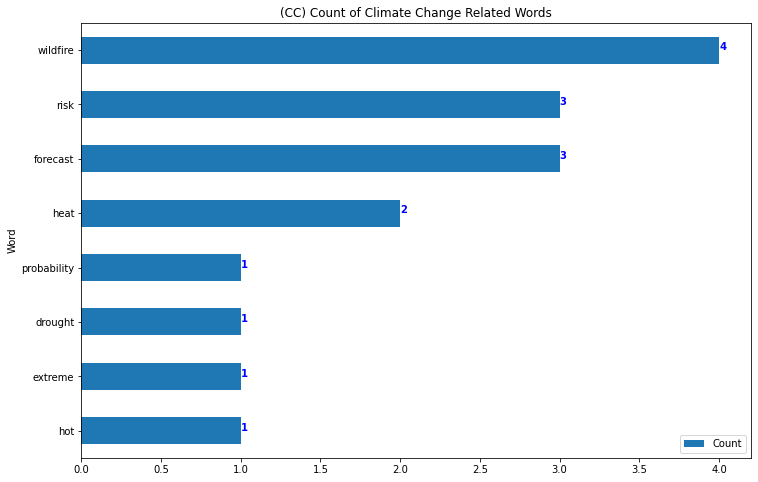

In [39]:
# CC
# cc climated related words found -- frequencies
cc_climate_change_words_found = list(cc_climate_change_words_df['Word'].unique())
print(cc_climate_change_words_found)

# set figure size
fig, ax = plt.subplots(figsize=(12, 8))
# plot horizontal bar plot
cc_climate_change_words_df.sort_values(by='Count').plot.barh(x="Word", y="Count", ax=ax)
# set the title
plt.title("(CC) Count of Climate Change Related Words")

for i, v in enumerate(cc_climate_change_words_df['Count'].sort_values()):
    ax.text(v, i , str(v),
            color = 'blue', fontweight = 'bold')

# plt.show()
cc_breakdown_png = f'reports/{STATION}/cc-climate-related-words-breakdown.png'
plt.savefig(cc_breakdown_png, transparent=False)

In [40]:
# total segments
total_segments = len(df)
total_segments


85

In [41]:
# unique segments
unique_segments = len(df[df['use_row'] == True])
unique_segments

26

In [42]:
# MY how many segments had climate related words/phrases — %

possible_climate_related_segments = len(df[(df["my_climate_words_found"].str.len() != 0) & (df["use_row"] == True)])
possible_climate_related_segments


f'{possible_climate_related_segments / unique_segments * 100.0} %'

'50.0 %'

In [43]:
# CC how many segments had climate related words/phrases — %

cc_possible_climate_related_segments = len(df[(df["cc_climate_words_found"].str.len() != 0) & (df["use_row"] == True)])
cc_possible_climate_related_segments


f'{cc_possible_climate_related_segments / unique_segments * 100.0} %'

'26.923076923076923 %'

In [44]:
my_climate_change_words_found.sort()
cc_climate_change_words_found.sort()

In [45]:
my_segments_w_climate_words_dict = df[(df['my_climate_words_found'].str.len() != 0) & (df["use_row"] == True)][['my_clean_words','matches']].to_dict('index')
cc_segments_w_climate_words_dict = df[(df['cc_climate_words_found'].str.len() != 0) & (df["use_row"] == True)][['cc_clean_words','matches']].to_dict('index')

In [46]:
my_climate_phrases_found = set([ p[0] for p in df.my_climate_phrases_found if p])
cc_climate_phrases_found = set([ p[0] for p in df.cc_climate_phrases_found if p])
    

In [47]:
# Word Doc

from docx import Document
doc = Document()
doc.add_heading(f'{STATION} summary')

doc.add_paragraph(f'Data can be found at: {csv}')
doc.add_paragraph(f'Total segments: {total_segments}')
doc.add_paragraph(f'Number of unique segments: {unique_segments} -- defined by matching other segments. match is defined as being 85% similar')
doc.add_paragraph(f'Found {possible_climate_related_segments} potential climate related segments when comparing (my) climate related words')
doc.add_paragraph(f'Found {cc_possible_climate_related_segments} potential climate related segments when comparing given (CC) climate related words')

doc.add_heading('Word Cloud:', level=1)
doc.add_picture(word_cloud_png)

doc.add_heading('Word Comparison: My words', level=1)
table = doc.add_table(rows=1, cols=2)
row = table.rows[0].cells
row[0].text = 'Word type'
row[1].text = 'Counts'

for word_type in my_comparison_df.index:
    
    row = table.add_row().cells
    row[0].text = word_type
    row[1].text = str(my_comparison_df.loc[word_type]['counts'])

doc.add_picture(my_pie_chart_png)


doc.add_heading('Climate Related Words Graph: My words', level=1)
doc.add_picture(my_breakdown_png)

doc.add_heading('List of My Climate Related Words Found', level=2)
for word in my_climate_change_words_found:
    doc.add_paragraph(word, style='List Bullet')

doc.add_paragraph().add_run().add_break()
    
doc.add_heading('List of My Climate Related Phrases Found', level=2)
if my_climate_phrases_found:
    for word in my_climate_phrases_found:
        doc.add_paragraph(word, style='List Bullet')
else:
    doc.add_paragraph('None')

doc.add_page_break()

doc.add_heading('Potential segments with my climate related words:', level=2)

for k, v in my_segments_w_climate_words_dict.items():
    para_start = doc.add_paragraph(f'*** row {k} ')
    if len(v['matches']) != 1 and v['matches'] != 'N/A':
        para_start.add_run(f"-- matches rows:  {v['matches']}")
    para_start.add_run('***')
    highlight_words(doc, v['my_clean_words'], CLIMATE_CHANGE_RELATED_WORDS)

doc.add_page_break()

doc.add_heading('Word Comparison: CC words', level=1)
table = doc.add_table(rows=1, cols=2)
row = table.rows[0].cells
row[0].text = 'Word type'
row[1].text = 'Counts'

for word_type in cc_comparison_df.index:
    
    row = table.add_row().cells
    row[0].text = word_type
    row[1].text = str(cc_comparison_df.loc[word_type]['counts'])

doc.add_picture(pie_chart_png_cc)

doc.add_heading('Climate Related Words Graph: CC words', level=1)
doc.add_picture(cc_breakdown_png)

doc.add_heading('List of CC Climate Related Words Found', level=2)
for word in cc_climate_change_words_found:
    doc.add_paragraph(word, style='List Bullet')

doc.add_paragraph().add_run().add_break()
    
doc.add_heading('List of My Climate Related Phrases Found', level=2)
if cc_climate_phrases_found:
    for word in cc_climate_phrases_found:
        doc.add_paragraph(word, style='List Bullet')
else:
    doc.add_paragraph('None')
    
doc.add_page_break()
    
doc.add_heading('Potential segments with CC climate related words:', level=2)
    
for k, v in cc_segments_w_climate_words_dict.items():
    para_start = doc.add_paragraph(f'*** row {k} ')
    if len(v['matches']) != 1 and v['matches'] != 'N/A':
        para_start.add_run(f"-- matches rows:  {v['matches']}")
    para_start.add_run('***')
    highlight_words(doc, v['cc_clean_words'], CC_WORDS)
    

doc.save(f"reports/{STATION}/{STATION}_summary.docx")